# Introduction to General Purpose GPU programming

### Why to use a GPU?
If you are a PC gamer you would have came across a gpu being one of the primary requirements to many modern games. Gpu's in computer gamming is used to render the graphics by *massive parallel computing*. This blog is aimed to give an simple introduction to the purpose of using gpu for computation.

#### Requirements:
Python 3.x

#### Packages required:
* matplotlib
* numpy

We will be using amdahl's law to estimate the speedup gain of a program and to apply amdahl's law in the context of code. Then we will be using Profiler module in python to find the bottlenecks in our code.

Before getting into amdahl's law we'll explore some key terms related to computation.

###### Latency : Refers to start to end duration of execution of a single instruction.
##### Throughput : Refers to number of computation that can be performed simultaneously.

We can get an idea of the increase in throughput by seeing how many cores
these new GPUs have. To give you an idea, the average Intel or AMD CPU
has only two to eight cores—while an entry-level, consumer-grade NVIDIA
GTX 1050 GPU has 640 cores, and a new top-of-the-line NVIDIA RTX
2080 Ti has 4,352 cores! We can exploit this massive throughput, provided
we know how properly to parallelize any program or algorithm we wish to
speed up. By parallelize, we mean to rewrite a program or algorithm so that
we can split up our workload to run in parallel on multiple processors
simultaneously.

### Amdahl's Law:
We will now explore Amdahl's Law, which is a simple arithmetic formula
that is used to estimate potential speed gain that may arise from
parallelizing some portion of code from a serial program onto multiple
processors.

There are two main portions of program we are concerned about, which are the code that is parallelizable and which are not parallelizable. The parallelizable code includes same instruction with different data streams where as non-parallelizable code includes code portions with different instruction and data streams.

We now know that if a portion of the code is parallelizable then if we increase number of cores in the processor( upgrading to a gpu with more number of cores) we can increase the speed or throughput of the program.

Amdahl's law is given by

$$ Speedup = \frac {1} {(1-p)+p/N} $$



Where 
* N --- > No of cores in the gpu.
* p --- > Parallelizable portion of code's execution time of the program.
* (1-p) --- >  Execution time of non-Parallelizable code (or serial code) in the program.

By the equation we can get an intution of speedup such as if we increase the number of cores we can increase the speed of the program or if we reduce the serial potion of code we can also speed up the program.

#### Mandelbrot set
 We are now prepared to see a very standard example for parallel computing
—an algorithm to generate an image of
the Mandelbrot set. Let's first define exactly what we mean.

For a given complex number, c, we define a recursive sequence for $ n >= 0 $, with $ Z _0  = 0 $ 

$$ z _n = z ^ 2 _{n-1}+c  $$

Create a jupyter notebook or click [here](https://githubtocolab.com/cvramanan/GPGPU_programming/blob/main/IntroGPGPU/Introduction_to_GPGPU_programming.ipynb) to open in colab and implement Mandelbrot set


 
    



In [1]:
from time import time
import matplotlib
#this will prevent the figure from popping up
# matplotlib.use('Agg')

from matplotlib import pyplot as plt
import numpy as np


def simple_mandelbrot(width, height, real_low, real_high, imag_low, imag_high, max_iters, upper_bound):
    
    real_vals = np.linspace(real_low, real_high, width)
    imag_vals = np.linspace(imag_low, imag_high, height)
        
    # we will represent members as 1, non-members as 0.
    
    mandelbrot_graph = np.ones((height,width), dtype=np.float32)
    
    for x in range(width):
        
        for y in range(height):
            
            c = np.complex64( real_vals[x] + imag_vals[y] * 1j  )            
            z = np.complex64(0)
            
            for i in range(max_iters):
                
                z = z**2 + c
                
                if(np.abs(z) > upper_bound):
                    mandelbrot_graph[y,x] = 0
                    break
                
    return mandelbrot_graph


    
    
    

We have created an image with Mandelbrot set. Let decode the simple_mandelbrot function which is used to create an image. We have passed the height and width of the image to be generated and the limits of the real and imaginary parts are given to the function and also the upper bounds has given to the function to create an image.

 
*** Profile printout saved to text file 'prun0'. 


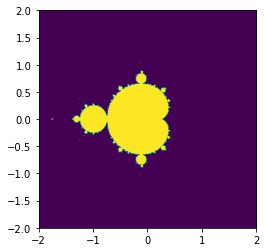

In [11]:
%%prun -s cumulative -q -l 10 -T prun0
mandel = simple_mandelbrot(512,512,-2,2,-2,2,256, 2.5)
fig = plt.figure(1)
plt.imshow(mandel, extent=(-2, 2, -2, 2))

We have used a tool called **prun** which is used to profile the code in a cell in jupyter and save the results in prun0 file. Then we read and display the file.

In [12]:
profiler = open('prun0', 'r')
print(profiler.read())
profiler.close()

         38675 function calls (38223 primitive calls) in 19.030 seconds

   Ordered by: cumulative time
   List reduced from 588 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   19.030   19.030 {built-in method builtins.exec}
        1    0.000    0.000   19.030   19.030 <string>:2(<module>)
        1   19.001   19.001   19.002   19.002 <ipython-input-1-e3c78b4ab0c6>:10(simple_mandelbrot)
        1    0.000    0.000    0.027    0.027 pyplot.py:2718(imshow)
        2    0.000    0.000    0.025    0.012 pyplot.py:2366(gca)
        2    0.000    0.000    0.025    0.012 figure.py:2021(gca)
        1    0.000    0.000    0.025    0.025 figure.py:1254(add_subplot)
        1    0.000    0.000    0.025    0.025 _subplots.py:18(__init__)
        1    0.000    0.000    0.024    0.024 _base.py:434(__init__)
        1    0.000    0.000    0.019    0.019 _base.py:1038(cla)


We can see that the total time taken by the program is ~19 sec in my computer (AMD® Ryzen 5 3550h).
If we calculculate Amdahl's law for mandelbrot set then **p** will be equal to **19.002(p = 99% of total executio time)** sec( time taken by simple_mandelbrot method which is a parallelizable portion of code) where the total time taken by the program is **19.030** , so the non-parallelizable code time will be **19.030-19.002 = 0.028 ((1-p) = 0.1% of total execution time)**. Let say we have a 640 core computer then **0.99/640 = 0.0015 (p/N)**  on applying the above data on Amdahl's law we get the speedup  
$$ speedup = \frac {1} {0.001 + 0.0015} = 400 \% $$

The speedup percent is very good and it is worth for us to speedup the algorithm with adding gpu support. This is a preliminary test that should be done on every problem that we intent to accelarate using GPU. On the follow up blogs we will add the gpu to right problems with python.